# MAPS model choices
Explore options for modeling the proportions of singletons against mutability. 

## Preliminaries

In [97]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from src.constraint import maps
from src import constants as C
from src import visualisation as vis

In [98]:
# Plotting styles and colors
plt.style.use(C.STYLE_DEFAULT)
palette = vis.color_palette()

In [99]:
# Load synonymous contexts
syn = pd.read_csv(C.PS_SYN_CONTEXT, sep="\t")
syn_copy = syn.copy()
print(f"Synonymous contexts: {len(syn)}")

Synonymous contexts: 304


In [100]:
# Drop contexts with no sungletons
syn = syn.query("n_singletons > 0")
print(f"Synonymous contexts with at least one singleton variant: {len(syn)}")

Synonymous contexts with at least one singleton variant: 258


Below we plot the relationship between proportion of singletons and mutability.

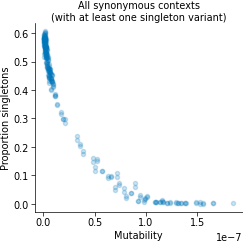

In [101]:
# Plot singletons vs mutability
x = syn["mu"]
y = syn["ps"]

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")

def plot_ps_vs_mu(x, y, ax = ax, **kwargs):
    """Plot proportion of singletons vs mutability."""

    ax.scatter(x, y, alpha=0.2, marker="o")
    ax.set_xlabel("Mutability")
    ax.set_ylabel("Proportion singletons")
    ax.set_title("All synonymous contexts\n(with at least one singleton variant)")

    return ax

plot_ps_vs_mu(x,y);


The relationship is slightly more linear after log transformation... 

Text(0.5, 1.0, 'All synonymous contexts\n(with at least one singleton variant)')

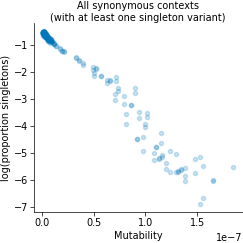

In [102]:
# Linearise the data
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")

ax.scatter(x, np.log(y), alpha=0.2, marker="o")
ax.set_xlabel("Mutability")
ax.set_ylabel("log(proportion singletons)")
ax.set_title("All synonymous contexts\n(with at least one singleton variant)")


And again not quite linear after square-root transformation.

Text(0.5, 1.0, 'All synonymous contexts\n(with at least one singleton variant)')

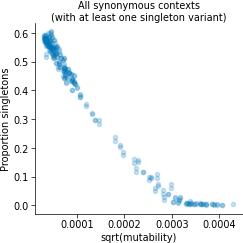

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")
ax.scatter(np.sqrt(x), y, alpha=0.2, marker="o")
ax.set_xlabel("sqrt(mutability)")
ax.set_ylabel("Proportion singletons")
ax.set_title("All synonymous contexts\n(with at least one singleton variant)")


It is not straightforward to linearise the data.

## Modelling CpGs and non-CpGs jointly

### Linear model of log(PS) vs mu

A log transformation of PS nearly linearises the data. How does a WLS model built on this transformed data perform across all synonymous contexts?

In [104]:
# Linear model for log(PS) vs mu
x = syn.mu
X = sm.tools.add_constant(x)
y = np.log(syn.ps)
w = syn["n_obs"]

model = sm.WLS(y, X, weights=w)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.991
Model:                            WLS   Adj. R-squared:                  0.991
No. Observations:                 258   F-statistic:                 2.981e+04
Covariance Type:            nonrobust   Prob (F-statistic):          5.77e-267
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5138      0.008    -67.644      0.000      -0.529      -0.499
mu          -3.96e+07   2.29e+05   -172.654      0.000   -4.01e+07   -3.91e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.38e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model seems to perform well. But the fitted values do not closely match the observed values. Especially for CpG contexts.

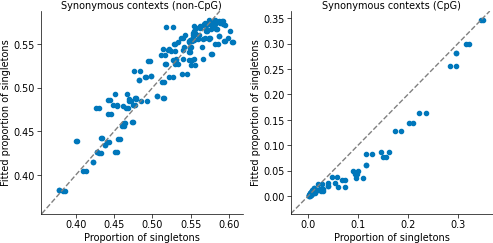

In [105]:
# Get fitted values
syn["fit_ps"] = np.exp(results.predict(sm.add_constant(syn.mu)))

# Separate CpG and non-CpG contexts
cpg = syn[syn.variant_type == "CpG"].copy()
non = syn[syn.variant_type == "non-CpG"].copy()

# Plot the data
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")

# Non-CpGs
axs[0].scatter(x=non.ps, y=non.fit_ps)
axs[0].set_title("Synonymous contexts (non-CpG)")

# CpGs
axs[1].scatter(x=cpg.ps, y=cpg.fit_ps)
axs[1].set_title("Synonymous contexts (CpG)")

# Add x = y line
for ax in axs:
    ax.axline(
        (min(ax.get_xlim()), min(ax.get_xlim())),
        slope=1,
        color="grey",
        linestyle="--",
    )
    ax.set_xlabel("Proportion of singletons")
    ax.set_ylabel("Fitted proportion of singletons")

### Polynomial equation for PS vs mu

A second degree polynomial does well for PS vs mu in CpG contexts. Could this approach be appplied to the whole dataset?

In [106]:
# Fit a polynomial equation to PS vs mu
x = syn.mu
y = syn.ps
w = syn.n_obs

z = np.polyfit(
    x,
    y,
    deg=2,
    w=w,
)
p = np.poly1d(z)

syn["fit_ps"] = p(syn.mu)

The model performs reasonably well...

In [107]:
# Get model statistics
model = sm.WLS(
    syn.fit_ps,
    sm.tools.add_constant(syn.mu),
    weights=w,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 fit_ps   R-squared:                       0.885
Model:                            WLS   Adj. R-squared:                  0.885
No. Observations:                 258   F-statistic:                     1973.
Covariance Type:            nonrobust   Prob (F-statistic):          2.57e-122
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4906      0.003    153.146      0.000       0.484       0.497
mu         -4.298e+06   9.68e+04    -44.423      0.000   -4.49e+06   -4.11e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.38e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

But again, the fitted values do not tally with the observed values.

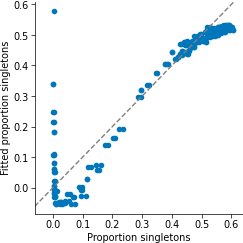

In [108]:
# Plot the fitted vs observed data
fig, ax = plt.subplots(1,1,figsize=(2.5, 2.5), layout="constrained")
ax.scatter(x = syn.ps, y = syn.fit_ps)
ax.set_xlabel("Proportion singletons")
ax.set_ylabel("Fitted proportion singletons")
ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())), slope=1, color="grey", linestyle="--"
);

### Polynomial equation for PS vs sqrt(mu)
What about with a square-root transformation of mu?

In [109]:
# Fit a polynomial equation to PS vs sqrt(mu)
x = np.sqrt(syn.mu)
y = syn.ps
w = syn.n_obs

z = np.polyfit(
    x,
    y,
    deg=2,
    w=w,
)
p = np.poly1d(z)

syn["fit_ps"] = p(np.sqrt(syn.mu))

In [110]:
# Get model statistics
model = sm.WLS(
    syn.fit_ps,
    sm.tools.add_constant(np.sqrt(syn.mu)),
    weights=w,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 fit_ps   R-squared:                       0.984
Model:                            WLS   Adj. R-squared:                  0.984
No. Observations:                 258   F-statistic:                 1.605e+04
Covariance Type:            nonrobust   Prob (F-statistic):          5.77e-233
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6130      0.002    345.647      0.000       0.610       0.617
mu         -1839.2038     14.516   -126.705      0.000   -1867.789   -1810.618
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

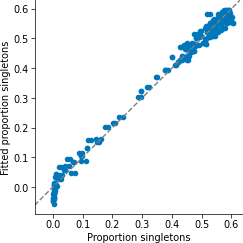

In [111]:
# Plot the fitted vs observed data
fig, ax = plt.subplots(1,1,figsize=(2.5, 2.5), layout="constrained")
ax.scatter(x = syn.ps, y = syn.fit_ps)
ax.set_xlabel("Proportion singletons")
ax.set_ylabel("Fitted proportion singletons")
ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())), slope=1, color="grey", linestyle="--"
);

This is much better, although the model is not performant for very highly mutable CpG sites. Let's test the performance of the model on our MAPS data.

In [112]:
# Calculate MAPS using the joint model, above.
df = pd.read_csv(C.PS_REGIONS, sep="\t")
maps.maps(df, p)

,csq,mu,n_singletons,n_obs,ps,ps_pred,maps,se,ci95
0,missense_variant,1.320782e-08,5958613,12358828,0.482134,0.683533,-0.201,0.000142,0.000279
1,stop_gained,1.749916e-08,238811,425204,0.561639,0.683520,-0.122,0.000761,0.001491
2,synonymous_variant,1.509552e-08,2412504,5579026,0.432424,0.683527,-0.251,0.000210,0.000411
3,distal_nmd,1.557515e-08,54382,101427,0.536169,0.683526,-0.147,0.001566,0.003069
4,long_exon,1.479470e-08,15857,26309,0.602722,0.683528,-0.081,0.003017,0.005913
5,nmd_target,1.934344e-08,145625,256243,0.568308,0.683514,-0.115,0.000978,0.001918
6,start_proximal,1.249526e-08,22947,41225,0.556628,0.683535,-0.127,0.002447,0.004796


The MAPS scores for synonymous sites are too high. This suggests that the model systematically under-estimates the proportion of singletons. This looks especially true for CpG sites in the scatter plot above.

## Modelling CpG and non-CpG contexts separately
One option is to model CpG and non-CpG contexts separately.

### Non-CpGs

Below we plot PS vs mu for non-CpG variants.

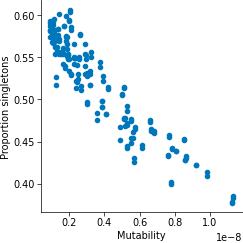

In [113]:
# Plot proportion of singletons vs mutability for non-CpG sites
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5), layout="constrained")
ax.scatter(x = non.mu, y = non.ps)
ax.set_xlabel("Mutability")
ax.set_ylabel("Proportion singletons");

The relationship is not quite linear, but it is made more so by a square root transformation of mu, as shown below.

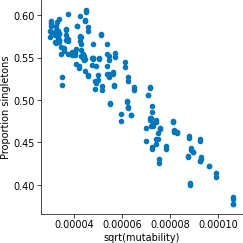

In [114]:
# Plot proportion of singletons vs sqrt(mu) for non-CpG sites
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5), layout="constrained")
ax.scatter(x = np.sqrt(non.mu), y = non.ps)
ax.set_ylabel("Proportion singletons")
ax.set_xlabel("sqrt(mutability)");

How does a model built on PS vs sqrt(mu) perform?

In [115]:
# WLS model for non-CpG contexts
x = np.sqrt(non.mu)
X = sm.tools.add_constant(x)
y = non.ps
w = non["n_obs"]

model = sm.WLS(y, X, weights=w)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.897
Model:                            WLS   Adj. R-squared:                  0.897
No. Observations:                 176   F-statistic:                     1519.
Covariance Type:            nonrobust   Prob (F-statistic):           6.99e-88
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6664      0.005    131.609      0.000       0.656       0.676
mu         -2578.1712     66.156    -38.971      0.000   -2708.742   -2447.600
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

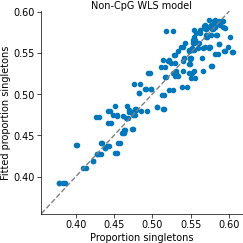

In [116]:
# Plotting fitted vs observed values for the non-CpG model
non["fit_ps"] = results.predict(sm.add_constant(np.sqrt(non.mu)))

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")

ax.scatter(x=non.ps, y=non.fit_ps)
ax.set_title("Non-CpG WLS model")
ax.set_xlabel("Proportion singletons")
ax.set_ylabel("Fitted proportion singletons")
ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())), slope=1, color="grey", linestyle="--"
);

It performs reasonably well.

### CpGs

Can we fit a polynomial to the CpG data with either:
- no transformations
- log-transformation of PS
- sqrt-transformation of mu?

Try first with no transformation.

In [117]:
# Fit a polynomial equation to PS vs mu
x = cpg.mu
y = cpg.ps
w = cpg.n_obs

z = np.polyfit(x, y, deg=2, w=w)
p = np.poly1d(z)

cpg["fit_ps"] = p(cpg.mu)

In [118]:
# Get model statistics
model = sm.WLS(cpg.fit_ps, sm.tools.add_constant(cpg.mu), weights=w)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 fit_ps   R-squared:                       0.895
Model:                            WLS   Adj. R-squared:                  0.894
No. Observations:                  82   F-statistic:                     684.3
Covariance Type:            nonrobust   Prob (F-statistic):           5.82e-41
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3303      0.010     31.744      0.000       0.310       0.351
mu         -2.775e+06   1.06e+05    -26.160      0.000   -2.99e+06   -2.56e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

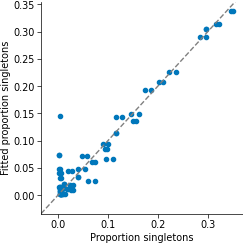

In [119]:
# Plot the fitted vs observed data
fig, ax = plt.subplots(1,1,figsize=(2.5, 2.5), layout="constrained")
ax.scatter(x = cpg.ps, y = cpg.fit_ps)
ax.set_xlabel("Proportion singletons")
ax.set_ylabel("Fitted proportion singletons")
ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())), slope=1, color="grey", linestyle="--"
);

This performs really nicely.

For consistency with the non-CpG data, can we apply a square-root transformation to mu for the CpG data also?

In [120]:
# Fit a polynomial equation to PS vs sqrt(mu)
x = np.sqrt(cpg.mu)
y = cpg.ps
w = cpg.n_obs

z = np.polyfit(x, y, deg=2, w=w)
p = np.poly1d(z)

cpg["fit_ps"] = p(np.sqrt(cpg.mu))

In [121]:
# Get model statistics
model = sm.WLS(cpg.fit_ps, sm.tools.add_constant(np.sqrt(cpg.mu)), weights=w)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 fit_ps   R-squared:                       0.944
Model:                            WLS   Adj. R-squared:                  0.944
No. Observations:                  82   F-statistic:                     1358.
Covariance Type:            nonrobust   Prob (F-statistic):           5.99e-52
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4760      0.011     42.530      0.000       0.454       0.498
mu         -1388.4689     37.681    -36.848      0.000   -1463.457   -1313.481
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

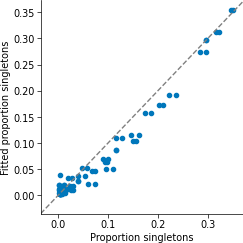

In [122]:
# Plot the fitted vs observed data
fig, ax = plt.subplots(1,1,figsize=(2.5, 2.5), layout="constrained")
ax.scatter(x = cpg.ps, y = cpg.fit_ps)
ax.set_xlabel("Proportion singletons")
ax.set_ylabel("Fitted proportion singletons")
ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())), slope=1, color="grey", linestyle="--"
);

This model does not fit the data so well.

## Conclusions

For now, let's try calculating MAPS for CpGs and non-CpGs separately. For non-CpGs, I will use a linear model of PS vs sqrt(mu). For CpGs, I will use a polynomial model of PS vs mu. We will see how it performs in practice.

## Plot proportion of singletons vs mutability

In [123]:
def plot_ps_vs_mu(ax, x, y, ylabel="Proportion singletons", xlabel="Mutability", title="All contexts"):

    ax.scatter(x, y, alpha=0.3, linewidths=0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    return None

In [124]:
def plot_ps_vs_mu_regression(ax, x, y, model, **kwargs):
    
    plot_ps_vs_mu(ax, x, y, **kwargs)

    Y = model.predict(sm.add_constant(x))
    ax.plot(x, Y)

    fig.text(x=1, y=0.9, s=rf"$R^2$ = {model.rsquared:.3f}", transform=ax.transAxes, ha="right", va="top")

NameError: name 'x1' is not defined

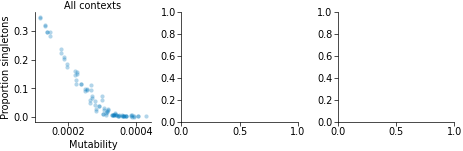

In [125]:
fig, axs = plt.subplots(1,3, figsize=(12*C.CM,4*C.CM), layout="constrained")

plot_ps_vs_mu(axs[0], x, y)
plot_ps_vs_mu_regression(axs[1], x1, np.log(y1), model, ylabel="Proportion\nsingletons (log)")
plot_ps_vs_mu_regression(axs[2], x2, np.log(y2), model2, ylabel="Proportion\nsingletons (log)", title="Non-CpG contexts")

for a, s in zip(axs, list("ABC")):
    panel_label(a,s)
    
plt.savefig("../plots/maps_model.svg", format="svg")
plt.savefig("../plots/maps_model.png", format="png", dpi=1000)